### PHYC 4250 - Final Project - Nour Allam

I chose to do image classification as it was a task that I felt we were not exposed to as much in class. I chose the "cats and dogs" dataset as it had plenty of data to work with, and is widely available for free use. I wanted to see if I could use a Recurrent Neural Network to do binary classification over images of cats and dogs. However, I encountered the challenge of the different Keras RNN-related layers and the Sklearn LogisticRegression module requiring that input data comes in a 1D format. So, I had to flatten the images to 1D arrays, which my intuition tells me would limit each model's ability to properly analyze the images, as it reduces its ability to make connections between the position of each pixel relative to others.

In [ ]:
import numpy as np
# loading 1d data
x_train = np.load('x_train.npy')
y_train = np.load('y_train.npy')
x_val = np.load('x_val.npy')
y_val = np.load('y_val.npy')
x_test = np.load('x_test.npy')
y_test = np.load('y_test.npy')

x_train_32 = np.load('x_train_32.npy')
y_train_32 = np.load('y_train_32.npy')
x_val_32 = np.load('x_val_32.npy')
y_val_32 = np.load('y_val_32.npy')
x_test_32 = np.load('x_test_32.npy')
y_test_32 = np.load('y_test_32.npy')

x_train_64 = np.load('x_train_64.npy')
y_train_64 = np.load('y_train_64.npy')
x_val_64 = np.load('x_val_64.npy')
y_val_64 = np.load('y_val_64.npy')
x_test_64 = np.load('x_test_64.npy')
y_test_64 = np.load('y_test_64.npy')

### Comment on Data Processing

I initially tried using Keras modules to process the data. However, I found it hard to work with the datatypes which those modules tended to format the data into, so I chose to process the images by hand using numpy. I flattened the data for the DNN and non-DNN sections, and returned it to its original 2D form for the RNN section and for visualization purposes. All the images were processed as grayscale for the sake of simplicity.

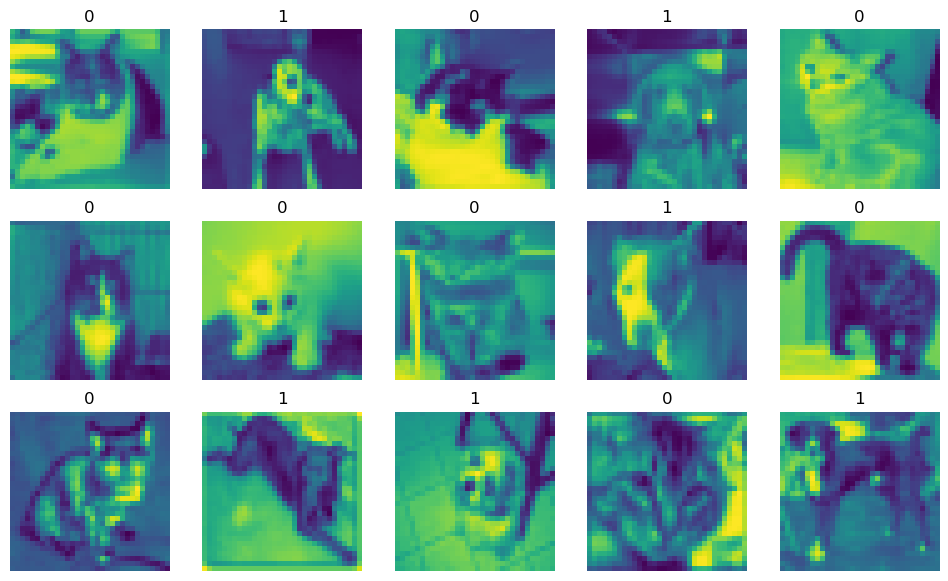

In [ ]:
import matplotlib.pyplot as plt
# visualizing some of the training data
plt.figure(figsize=(12, 12))
for i, img in enumerate(x_train_32):
    if i > 14: break
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(np.array(img))
    plt.title(y_train_32[i])
    plt.axis("off")

### Creating a basic DNN

I created a DNN model very similar to the one I used in my PS2 submission. It involves an input layer, a single hidden layer, and an output layer. The number of nodes in the hidden layer is determined by the tuner. So is the activation functions of the hidden and output layers, and the decision to apply a Dropout layer.

In [ ]:
import keras
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

def build_model(hp):
    # instantiate model
    model = Sequential()
    # add input layer
    input_layer = keras.Input(shape=x_train_64.reshape(7204, 4096)[0].shape)
    model.add(input_layer)
    # add a hidden layer, tuning number of nodes, and dimensionality of output
    model.add(Dense(hp.Int('units',  min_value=127, max_value=1048, step=64), hp.Choice('activation', values=['softmax', 'relu', 'tanh', 'sigmoid'])))
    # apply dropout with rate 0.5, allow for tuning whether dropout is added or not
    if hp.Boolean("dropout"):
        model.add(Dropout(0.5))
    # output layer, tuning activation function
    model.add(Dense(1, hp.Choice('activation', values=['softmax', 'relu', 'tanh'])))
    # compiling model
    model.compile(loss='mse')
    print('Model architecture created successfully!')
    return model

In [ ]:
import keras_tuner

# tuning hyperparameters
tuner = keras_tuner.RandomSearch(
    build_model,
    max_trials=5, project_name="DNN-Tuning", objective='val_loss', overwrite=True)
tuner.search(x_train_64.reshape(7204, 4096), y_train_64, epochs=5, validation_data=(x_val_64.reshape(801, 4096), y_val_64))

# print summary of search results
tuner.results_summary()

# build a new model with best hyperparameters
best_hps = tuner.get_best_hyperparameters()[0]
model_DNN = build_model(best_hps)
model_DNN.summary()

Trial 5 Complete [00h 00m 05s]
val_loss: 0.24904589354991913

Best val_loss So Far: 0.24904589354991913
Total elapsed time: 00h 00m 46s
Results summary
Results in ./DNN-Tuning
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 4 summary
Hyperparameters:
units: 319
activation: tanh
dropout: True
Score: 0.24904589354991913

Trial 2 summary
Hyperparameters:
units: 959
activation: tanh
dropout: True
Score: 0.39929503202438354

Trial 3 summary
Hyperparameters:
units: 383
activation: relu
dropout: True
Score: 0.4956304728984833

Trial 0 summary
Hyperparameters:
units: 1023
activation: softmax
dropout: False
Score: 0.5043695569038391

Trial 1 summary
Hyperparameters:
units: 575
activation: softmax
dropout: False
Score: 0.5043695569038391
Model architecture created successfully!
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 319) 

64/64 [==============================] - 0s 805us/step
Accuracy of the DNN classifier on the test set is: 0.5002471576866041


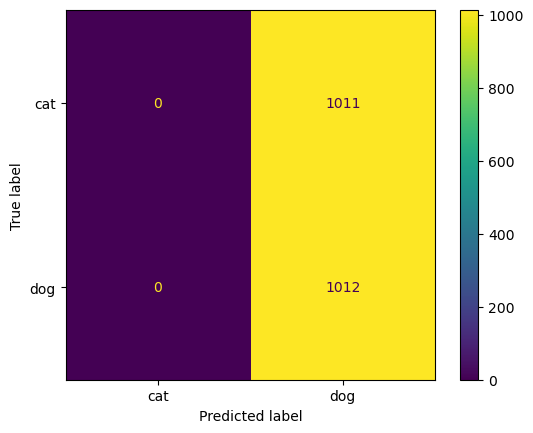

AUC of the DNN classifier on the test set is: 0.5


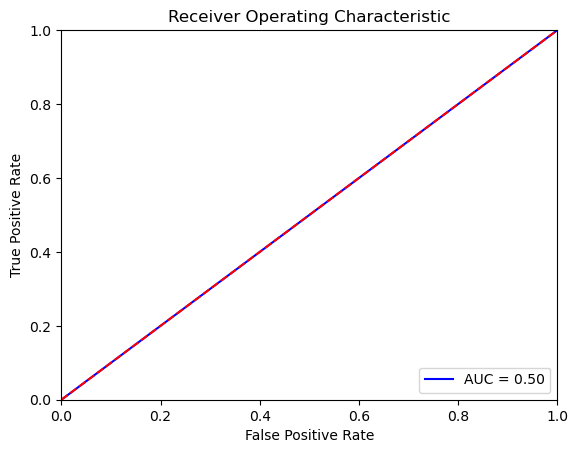

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc, accuracy_score

# now performing classification task
model_DNN.fit(x=x_train_64.reshape(7204, 4096), y=y_train_64)
y_pred = model_DNN.predict(x_test_64.reshape(2023, 4096)) > 0.5

# calculating the accuracy of classifier
print("Accuracy of the DNN classifier on the test set is: {0}".format(accuracy_score(y_test_64, y_pred)))

# create a confusion matrix
cm = confusion_matrix(y_test_64, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['cat', 'dog'])
cm_display.plot()
plt.show()

# plot roc-auc curve, copied from
# https://medium.com/analytics-vidhya/evaluation-metrics-for-classification-problems-with-implementation-in-python-a20193b4f2c3
fpr, tpr, threshold = roc_curve(y_test_64, y_pred)
roc_auc = auc(fpr, tpr)

# printing AUC
print("AUC of the DNN classifier on the test set is: {0}".format(roc_auc))

# plotting the ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

My DNN essentially failed, as shown by the graphs. The Receiver Operating Characteristic (ROC) curve appeared to be nearly aligned with the true positive rate = false positive rate line, and the value of the area under that curve (AUC) was 0.50. The accuracy score (\frac{|\text{predicted} \cap \text{true}|}{|\text{predicted} \cup \text{true}|}) was also approximately 0.50. Later on, I tried using the number of pixels from 180**2 to 64**2 (and then later to 32**2) but none of these changes seem to have had any impact on the results displayed ny the model.

This may be tied to the fact that it's a very simple DNN, but more importantly, that it takes a flattened version of each image, and has seemingly no way of learning from those images other than analyzing the grayscale intensity of each pixel. I talk more about the importance of understanding the spatial relationship between pixels in an image in the 'non-DNN' section. The model seems to have guessed every single image to be a dog, which indicates that its failure might also be a massive overfitting issue. Since the model has to take in an 180*180 array (equivalent to the size of a flattened image matrix), it is essentially trying to analyze a dataset with 180*180 features. Realizing this, I don't know why I thought this would work at all.


### Using a non-DNN method

I used a default-parameter LogisticRegression model which yielded about 50% overall accuracy. The ROC curve appeared to be nearly aligned with the true positive rate = false positive rate line, and the AUC value was approximately 0.517. The accuracy score was approximately 0.517 as well. These results can likely be explained by my use of flattened images as input to this model. Interestingly, unlike the DNN (and later, RNN) models, this model does not classify all images as either a cat or dog, but makes mistakes on 50% of the dataset equally. This could be due to the fact that Logistic Regression is not as complex as DNNs and RNNs, and may therefore be less likely to overfit the data. As I mentioned earlier, it intuitively seems wrong to use flattened images as input as that reduces a model's ability to learn the data properly. However, upon doing more research on the topic I found that flattening images causes issues specifically when it comes to the loss of spatial information, and increased complexity for models.

Note: I later changed the number of pixels in each picture from 180**2 (which is what yielded the results above) to 32**2. This effectively increased the model's accuracy by about 2%, raising the AUC value to 0.54, as shown below. What is interesting is that the LogisticRegression model was the only one that displayed improvement with pixel reduction. From reading online, this may be due to the fact that logistic regression is often preferred when the training data set size is relatively small. Intuitively, it might also be the fact that it is relatively less complex that allows is to hone-in on the more important features (pixels) of each image.

Accuracy of the non-DNN classifier on the test set is: 0.5442412259021255


/Users/nourallam/anaconda3/envs/final_2/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


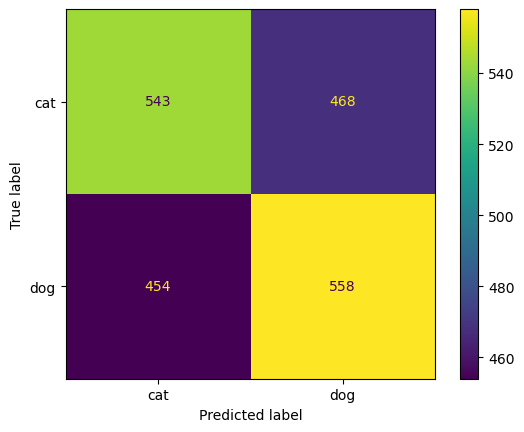

AUC of the non-DNN classifier on the test set is: 0.5442376936700251


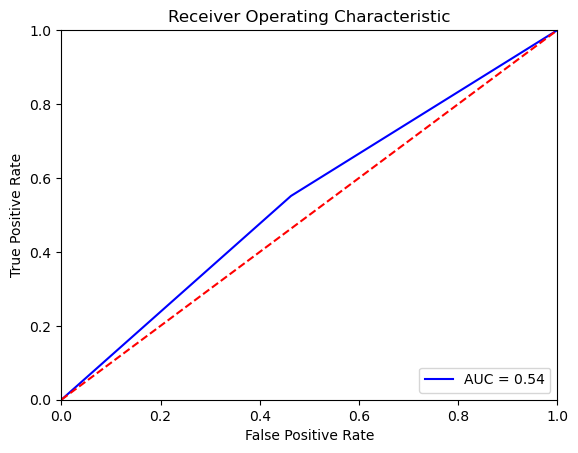

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, accuracy_score

# create and fit basic model
non_dnn_model = LogisticRegression()
non_dnn_model.fit(x_train_32.reshape(7204, 1024), y_train_32)

# now perform the classification task on the test set
y_pred = non_dnn_model.predict(x_test_32.reshape(2023, 1024))

# calculating the accuracy of classifier
print("Accuracy of the non-DNN classifier on the test set is: {0}".format(accuracy_score(y_test_32, y_pred)))

# create a confusion matrix
cm = confusion_matrix(y_test_32, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['cat', 'dog'])
cm_display.plot()
plt.show()

# plot roc-auc curve, copied from
# https://medium.com/analytics-vidhya/evaluation-metrics-for-classification-problems-with-implementation-in-python-a20193b4f2c3
fpr, tpr, threshold = roc_curve(y_test_32, y_pred)
roc_auc = auc(fpr, tpr)

# printing AUC
print("AUC of the non-DNN classifier on the test set is: {0}".format(roc_auc))

# plotting the ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Spatial information is important as it allows models to localize and recognize objects of an image, and understand the relationship between those objects and the rest of the image's features. Reflecting on this issue made me consider using convolutional neural networks (CNNs) in combination with my RNN as they are commonly used for image classification, and may be capable of analyzing the geometry of an image to identify its subjects. While their ability to learn image classes is highly vulnerable to alterations to an image's orientation, as they are capable of identifying different subjects in an image but not the relationship between these subjects or their relevance to the image (as far as I understand), my intuition told me that they would be better than only using an RNN, as RNNs are more commonly used for text-based classification.

### Using a new technique (RNN)

I made several trial-and-error attempts to make my idea of using RNNs to classify images work, but none of them seem to have work. At first, I tried simply replacing the single hidden layer I used in my DNN with a Keras SimpleRNN layer to see if that basic change would have any effect on the model's performance. It did not. I tried incorporating  combinations of long short-term memory (LSTM) and gated recurrent unit (GRU) layers, but none of those seemed to improve the performance very much. Lastly, as I mentioned I would earlier, I tried combining RNN and CNN components. I created a model which has 2 CNN layers, each consisting of one convolution and one pooling layer, and paired them with a simpleRNN layer, followed by a Reshaping layer, Dropout layer, then an output Dense layer. The reason I chose this configuration is because I wanted to work with a network that is simple and appropriate to my level of understanding of CNNs. The convolution layer applies filters to each image to learn its features, and the pooling layer reduces the representation of these learned features to a compressed form. I expected the RNN to then take the properly reshaped form of these learned features and use it to classify. The output and Dropout layers exist as an artifact of the DNN layer I created earlier, just for the sake of keeping the two models fairly comparable.

Note: similar to the basic DNN model, changing the number of pixels to 32**2 had no effect on this model's performance.

In [ ]:
from keras.layers import SimpleRNN, Dropout, Conv2D, MaxPooling2D, Reshape, Dense
from keras.models import Sequential
import keras

def build_model_rnn(hp):
    # instantiate model
    model = Sequential()
    # tuning some hyperparameters
    conv_activation = hp.Choice('activation', values=['softmax', 'relu', 'tanh'])
    rnn_activation = hp.Choice('activation', values=['softmax', 'relu', 'tanh'])
    # convolution layer
    model.add(Conv2D(36, (3, 3), input_shape=(32, 32, 1), activation=conv_activation))
    # pooling layer
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # convolution layer
    model.add(Conv2D(36, (3, 3), input_shape=(32, 32, 1), activation=conv_activation))
    # pooling layer
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # convolution layer
    model.add(Conv2D(36, (3, 3), input_shape=(32, 32, 1), activation=conv_activation))
    # pooling layer
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # reshaping
    model.add(Reshape((12, 12)))
    # adding only one RNN layer, for the sake of making this model
    # comparable to the "vanilla" version, tuning dimensionality of output
    # (tuning number of nodes)
    model.add(SimpleRNN(hp.Int('units',   min_value=127, max_value=1048, step=64), activation=rnn_activation))
    # apply dropout with rate 0.5
    model.add(Dropout(0.5))
    # output layer, tuning activation function
    model.add(Dense(1,activation='softmax'))
    # compiling model
    model.compile(loss='mse')
    print('Model architecture created successfully!')
    return model

In [ ]:
import keras_tuner as kt

# tuning hyperparameters
tuner_rnn = kt.RandomSearch(
    build_model_rnn, overwrite=True,
    objective='val_loss', project_name='RNN-Tuning', max_trials=5)
tuner_rnn.search(x_train_32, y_train_32, epochs=5, validation_data=(x_val_32, y_val))

# print summary of search results
tuner_rnn.results_summary()

# build a new model with best hyperparameters
best_hps = tuner_rnn.get_best_hyperparameters()[0]
model_RNN = build_model_rnn(best_hps)
model_RNN.summary()

Trial 5 Complete [00h 00m 24s]
val_loss: 0.5355805158615112

Best val_loss So Far: 0.5355805158615112
Total elapsed time: 00h 02m 16s
Results summary
Results in ./RNN-Tuning
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0 summary
Hyperparameters:
activation: tanh
units: 447
Score: 0.5355805158615112

Trial 1 summary
Hyperparameters:
activation: softmax
units: 1023
Score: 0.5355805158615112

Trial 2 summary
Hyperparameters:
activation: relu
units: 703
Score: 0.5355805158615112

Trial 3 summary
Hyperparameters:
activation: tanh
units: 959
Score: 0.5355805158615112

Trial 4 summary
Hyperparameters:
activation: relu
units: 767
Score: 0.5355805158615112
Model architecture created successfully!
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 30, 30, 36)        360       
                                                      

64/64 [==============================] - 0s 4ms/step
Accuracy of the RNN classifier on the test set is: 0.5002471576866041


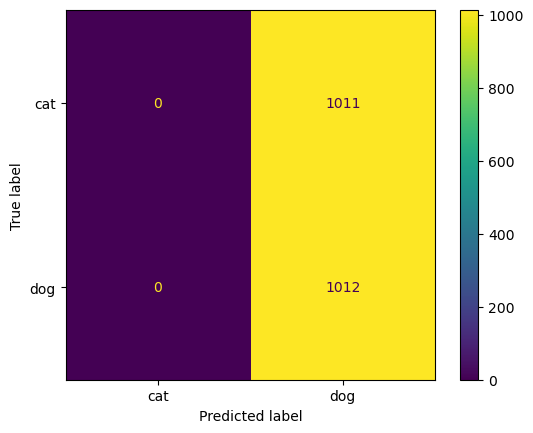

AUC of the RNN classifier on the test set is: 0.5


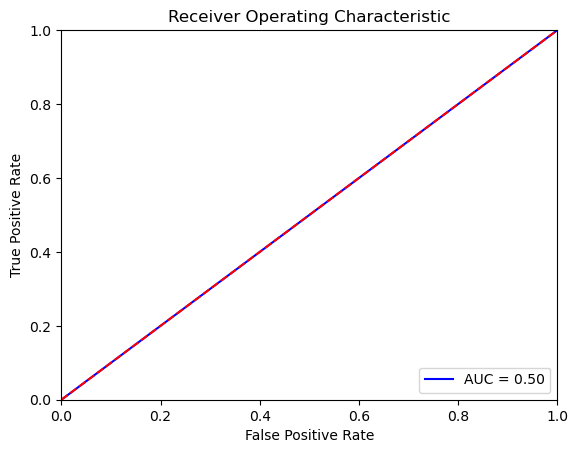

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc, accuracy_score

# now performing classification task
model_RNN.fit(x=x_train_32, y=y_train_32)
y_pred = model_RNN.predict(x_test_32)

# calculating the accuracy of classifier
print("Accuracy of the RNN classifier on the test set is: {0}".format(accuracy_score(y_test_32, y_pred)))

# create a confusion matrix
cm = confusion_matrix(y_test_32, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['cat', 'dog'])
cm_display.plot()
plt.show()

# plot roc-auc curve, copied from
# https://medium.com/analytics-vidhya/evaluation-metrics-for-classification-problems-with-implementation-in-python-a20193b4f2c3
fpr, tpr, threshold = roc_curve(y_test_32, y_pred)
roc_auc = auc(fpr, tpr)

# printing AUC
print("AUC of the RNN classifier on the test set is: {0}".format(roc_auc))

# plotting the ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

However, none of these additions seems to have affected the performance of the model, as it displayed metrics identical to the DNN created earlier. Moreover, after printing out a summary of the model, I realized that the number of parameters it was training on was way larger than the number I predicted, 587162! That number was even larger for the DNN, 14484143! It is no wonder that the networks were unable to make any meaningful predictions, as data at that point (I would expect) just turns into inputs of noise. I tried searching-up how to deal with this issue, and some of the sources said that I should add more convolutional layers so as to reduce the dimensionality of the data being processed, so I added a few more convolution-pooling pairs to see what would happen.

Unsurprisingly, adding extra convolution did not seem to change the model's performance at all. This tells me that the issue with how I tackled this classification problem may have been more closely related to the way in which I preprocessed and processed the through each model.

### Conclusion

To conclude things, I think that the biggest issue I faced with this project is that I did not have the time to build a deep-enough understanding of neural networks, particularly CNNs, that would allow me to utilize them to their fullest potential. Amusingly, the Logistic Regression model technically did better than the other two techniques as it made mistakes on both prediction classes equally, rather than only classifying into one or the other. Ultimately, I think the biggest issue that I presented my models with was over-fitting, and improperly formatted data. Since I have never done image classification independently, I likely missed a lot of conventions that might have been used to present the models of more meaningful data. The issue of over-fitting comes back to my insufficient familiarity with the RNN and CNN structures, as I am sure that there are piles of code online that were able to successfully classify the 'cat dog' image dataset using some neural network technique. For future learning, I do want to look into CNN-RNN combination models, whether they are effective and how commonly they are used. One way that I could start doing that is by going through this paper, 'CNN and RNN mixed model for image classification', which I found while searching online.

https://www.matec-conferences.org/articles/matecconf/pdf/2019/26/matecconf_jcmme2018_02001.pdf


References:

Code on Keras Tuner: https://keras.io/keras_tuner/

Loading images in ways other than Keras: https://www.geeksforgeeks.org/how-to-iterate-over-files-in-directory-using-python/

References for some of the information involved in discussion:
- https://medium.com/@saba99/spatial-information-8465a276cbc7
- https://towardsdatascience.com/capsule-neural-networks-are-here-to-finally-recognize-spatial-relationships-693b7c99b12
- https://stackoverflow.com/questions/51391083/why-does-my-keras-model-have-so-many-parameters
- https://medium.com/@mohsin.shaikh324/a-comparative-analysis-logistic-regression-vs-artificial-neural-networks-5cbc854109ab#:~:text=In%20conclusion%2C%20while%20Artificial%20Neural,a%20need%20for%20model%20interpretability.

Trying to get a basic CNN to work.

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten, Dropout

# define cnn model
def build_model_exp():
 model = Sequential()
 model.add(Conv2D(36, (3, 3), activation='relu',input_shape=(32, 32, 1)))
 model.add(MaxPooling2D((2, 2)))
 model.add(Conv2D(36, (3, 3), activation='relu' ,input_shape=(32, 32, 1)))
 model.add(MaxPooling2D((2, 2)))
 model.add(Conv2D(36, (3, 3), activation='relu', input_shape=(32, 32, 1)))
 model.add(MaxPooling2D((2, 2)))
 model.add(Flatten())
 model.add(Dense(128, activation='relu'))
 model.add(Dropout(0.5))
 model.add(Dense(1, activation='softmax'))
 # compile model
 model.compile(loss='mse')
 return model

In [ ]:
model_experimental = build_model_exp()
model_experimental.summary()
model_experimental.fit(x=x_train_32, y=y_train_32)
model_experimental.evaluate(x_test_32)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 36)        360       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 36)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 36)        11700     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 36)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 36)        11700     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 36)         0

2024-04-19 21:51:25.816978: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


64/64 [==============================] - 0s 247us/step - loss: 0.0000e+00


0.0

64/64 [==============================] - 0s 7ms/step
Accuracy of the RNN classifier on the test set is: 0.5002471576866041


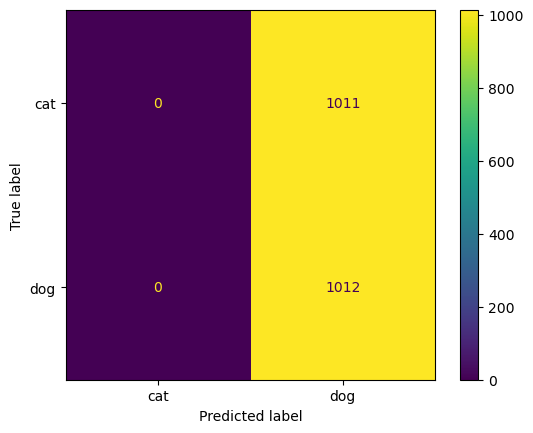

AUC of the RNN classifier on the test set is: 0.5


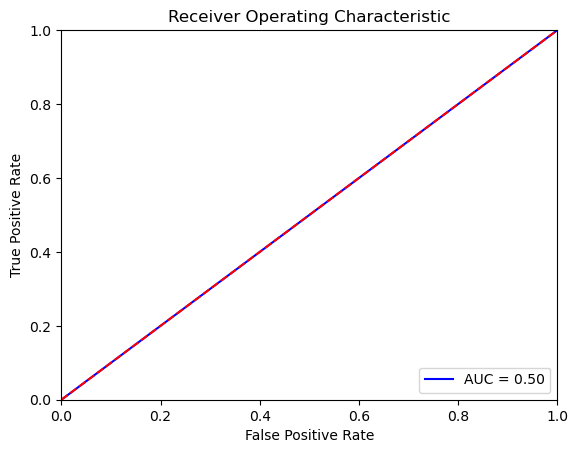

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc, accuracy_score

# now performing classification task
model_experimental.fit(x=x_train_32, y=y_train_32)
y_pred = model_experimental.predict(x_test_32)

# calculating the accuracy of classifier
print("Accuracy of the RNN classifier on the test set is: {0}".format(accuracy_score(y_test_32, y_pred)))

# create a confusion matrix
cm = confusion_matrix(y_test_32, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['cat', 'dog'])
cm_display.plot()
plt.show()

# plot roc-auc curve, copied from
# https://medium.com/analytics-vidhya/evaluation-metrics-for-classification-problems-with-implementation-in-python-a20193b4f2c3
fpr, tpr, threshold = roc_curve(y_test_32, y_pred)
roc_auc = auc(fpr, tpr)

# printing AUC
print("AUC of the RNN classifier on the test set is: {0}".format(roc_auc))

# plotting the ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()